In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset, save_dataset, load_dataset
# from src.TFT_Flowmatching import TemporalFusionTransformerDiffusion

from src.VQVAE import VQVAE
from typing import Optional
import pickle

import torch.utils
import torch.utils.data

## Optional: direct load data from Cache

In [2]:
train = load_dataset('../data/.cache/train.pkl')
test = load_dataset('../data/.cache/test.pkl')
stats_dict = pickle.load(open('../data/.cache/stats_dict.pkl', 'rb'))
feature_dim = stats_dict['feature_dim']
features = stats_dict['features']

lookback = 30
future_steps = 40
resample = False
dir = '../data/Phase3/Modified/'
ds = MyDataset(lookback=lookback)
train_batch_size = 32
test_batch_size = 128

In [12]:


def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.columns = df.columns.str.strip() 
    
    df = df.rename(columns={'State': 'state'})

    states = ['At Station', 'Error', 'Wait', 'Cross', 'Approach Sidewalk',
       'Approach Target Station', 'Move Along Sidewalk']

    states_ohe = pd.get_dummies(df['state'], prefix='state')
    cur_states = df['state'].unique()
    for state in states:
        if state not in cur_states:
            states_ohe['state_'+state] = 0

    df = pd.concat([df, states_ohe], axis=1)
    df.drop(columns=['state'], inplace=True)
    
    df.dropna(inplace=True, how='any')
    if resample:
        f_per_sec = df.groupby('TimestampID').count().mean().mean()
        if f_per_sec < target_freq:
            raise ValueError('The frequency of the data is lower than the target frequency')
        elif int(f_per_sec) == target_freq:
            pass
        else:
            resample_ratio = int(f_per_sec/target_freq)
            df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget', 
                          'start_station_X', 'start_station_Y', 'end_station_X', 'end_station_Y',
                          'distance_from_start_station_X',
                            'distance_from_start_station_Y', 'distance_from_end_station_X',
                            'distance_from_end_station_Y', 'facing_start_station',
                            'facing_end_station', 
                            'rolling_avg', 
                            'User', 'Type', 
                            'possible_interaction'
                          ]:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]
    
    # keep numeric columns
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df, agv_col_name="scenario")


In [13]:
# df = process_data(dir+file)
# df = df[df['scenario'] == 7]

# uer_x, uer_y = df['User_X'].values[10:40], df['User_Y'].values[10:40]

# plt.plot(uer_x, uer_y)
# # same
# plt.title('User Position')
# plt.xlabel('X')
# plt.ylabel('Y')
# # equal aspect ratio
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

### Optional: shuffle the dataset

In [14]:
# import random
# random.shuffle(ds.dataset)

In [15]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

feature_dim = ds.feature_dim
stats_dict['feature_dim'] = feature_dim
stats_dict['features'] = ds.dataset[0].columns
columns = [_ for _ in ds.dataset[0].columns if _ not in ['AGV_name']]
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'facing_along_sidewalk',
       'facing_to_road', 'On_sidewalks', 'On_road', 'closest_station',
       'distance_to_closest_station', 'distance_to_closest_station_X',
       'distance_to_closest_station_Y', 'looking_at_AGV', 'GazeDirection_X',
       'GazeDirection_Y', 'GazeDirection_Z', 'AGV_X', 'AGV_Y',
       'looking_at_closest_station', 'data_active', 'scenario',
       'state_Approach Sidewalk', 'state_Approach Target Station',
       'state_At Station', 'state_Cross', 'state_Error',
       'state_Move Along Sidewalk', 'state_Wait'],
      dtype='object') 
feature_dim : 38


['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station']

In [3]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train) * train_batch_size, len(test) * test_batch_size)

# # save it to cache to speed up
# save_dataset(train, type='train', file_path='../data/.cache/train.pkl')
# save_dataset(test, type='test', file_path='../data/.cache/test.pkl')
# pickle.dump(stats_dict, open('../data/.cache/stats_dict.pkl', 'wb'))


torch.Size([32, 30, 38]) torch.Size([32, 40, 38])
317856 70656


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from src.VQVAE import VQVAE
import math

###############################################
# Original Blocks (with minor efficiency tweaks)
###############################################

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_rate=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.gate = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_input = x
        for layer, norm in zip(self.layers, self.norms):
            x = F.relu(layer(x))
            x = self.dropout(x)
            x = norm(x)
        gate = torch.sigmoid(self.gate(x))
        x2 = self.fc2(x)
        return self.fc3(x_input) + gate * x2

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        # x: (seq_len, batch, hidden_size)
        x2 = x
        x = self.norm1(x)
        x, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = x + x2
        x2 = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = x + x2
        return x

###############################################
# Diffusion–based Decoder
###############################################

class SinusoidalTimeEmbedding(nn.Module):
    """
    Computes a sinusoidal embedding for a scalar timestep.
    """
    def __init__(self, embedding_dim):
        super(SinusoidalTimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # t: Tensor of shape (batch,) or (batch, 1)
        if len(t.shape) == 1:
            t = t.unsqueeze(1)  # (batch, 1)
        half_dim = self.embedding_dim // 2
        # Compute constant
        emb_factor = math.log(10000) / (half_dim - 1)
        # Create a tensor of shape (half_dim,)
        dims = torch.arange(half_dim, device=t.device, dtype=t.dtype)
        # (batch, half_dim)
        emb = t * torch.exp(-dims * emb_factor)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        # If embedding_dim is odd, pad an extra zero.
        if self.embedding_dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb  # (batch, embedding_dim)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def compute_flow_target(noise, y_batch, t):
    """
    Compute the intermediate sample x_t and target velocity for flow-matching.
    
    Args:
        noise: Tensor of shape (batch, num_action_steps, action_dim), noise sample
        y_batch: Tensor of shape (batch, num_action_steps, action_dim), ground truth actions
        t: Tensor of shape (batch, 1, 1), time steps
    
    Returns:
        x_t: Intermediate sample at time t
        v_target: Target velocity
    """
    t = t.view(-1, 1, 1)  # Ensure t is [batch, 1, 1]
    x_t = t * noise + (1 - t) * y_batch

    v_target = noise - y_batch
    return x_t, v_target

class DiffusionDecoder(nn.Module):
    def __init__(self, action_dim, conditioning_dim, num_diffusion_steps=10,
                 num_action_steps=20, hidden_dim=128, num_layers=2, noise_weight=1, num_heads=4, ):
        super().__init__()
        self.action_dim = action_dim
        self.num_diffusion_steps = num_diffusion_steps  # Number of integration steps
        self.hidden_dim = hidden_dim
        self.num_action_steps = num_action_steps
        self.noise_weight = noise_weight

        self.time_embed = SinusoidalTimeEmbedding(hidden_dim)
        self.time_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.SiLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

        input_dim = hidden_dim + hidden_dim + num_action_steps * action_dim

        # # Output processing
        # self.output_proj = nn.Sequential(
        #     nn.Linear(hidden_dim * 4, hidden_dim * 2),
        #     nn.LayerNorm(hidden_dim * 2),
        #     nn.SiLU(),
        #     nn.Linear(hidden_dim * 2, num_action_steps * action_dim)
        # )

        # Build a deeper network with LayerNorm and residual connections
        self.fc1 = nn.Linear(input_dim, 512)
        self.ln1 = nn.LayerNorm(512)
        
        self.fc2 = nn.Linear(512, 512)
        self.ln2 = nn.LayerNorm(512)
        
        self.fc3 = nn.Linear(512, 512)
        self.ln3 = nn.LayerNorm(512)
        
        self.fc_out = nn.Linear(512, num_action_steps * action_dim)

        # Final output projection
        self.out = nn.Linear(hidden_dim, action_dim)

        # self.gate = nn.Linear(conditioning_dim, action_dim * num_action_steps)
        # self.fc_direct = nn.Linear(num_action_steps * action_dim, num_action_steps * action_dim)

    def forward(self, conditioning, x_t, t):
        """
        Args:
            conditioning: Tensor of shape (batch, cond_len, hidden_dim)
            x_t: Tensor of shape (batch, num_action_steps, action_dim)
            t: Tensor of shape (batch,) with time values in [0,1]
        """
        # Time embedding
        t_emb = self.time_embed(t)  # [batch, hidden_dim]

        x_t = x_t.view(x_t.size(0), -1)  # Flatten the last two dimensions
        x_with_time = torch.cat([x_t, t_emb], dim=-1)  # [batch, hidden_dim + cond_dim]

        conditioning = torch.mean(conditioning, dim=1)  # [batch, hidden_dim]
        x_proj = torch.cat([x_with_time, conditioning], dim=-1)  # [batch, hidden_dim + cond_dim]

        # Pass through the network with normalization and residual connections
        x = F.relu(self.ln1(self.fc1(x_proj)))
        residual = x
        x = F.relu(self.ln2(self.fc2(x)) + residual)
        residual = x
        x = F.relu(self.ln3(self.fc3(x)) + residual)
        h = self.fc_out(x)

        # gate = torch.sigmoid(self.gate(conditioning))
        # h = h * gate + self.fc_direct(x_t)
        
        h = h.view(h.size(0), self.num_action_steps, self.action_dim)  # Reshape to [batch, num_action_steps, action_dim]
        
        
        return h  # [batch, num_action_steps, action_dim]

    def decoder_train_step(self, conditioning, y_batch, device):
        """
        Performs one training step for the flow-matching decoder.
        
        Args:
            conditioning: Tensor of shape (batch, cond_len, conditioning_dim)
            y_batch: Ground truth trajectory (batch, num_action_steps, action_dim)
            device: torch.device
        
        Returns:
            loss: The MSE loss between predicted and target velocity
        """
        batch_size = y_batch.size(0)
        # Sample t uniformly from [0,1]
        t = torch.rand(batch_size, device=device)  # [batch]
        t = t.unsqueeze(1).unsqueeze(2)  # [batch, 1, 1]
        
        # Sample noise
        noise = torch.randn_like(y_batch) * self.noise_weight
        
        # Compute x_t and v_target
        x_t, v_target = compute_flow_target(noise, y_batch, t)
        
        # Predict velocity
        v_pred = self.forward(conditioning, x_t, t.squeeze(2).squeeze(1))  # t: [batch]
        
        # MSE loss
        loss = F.mse_loss(v_pred, v_target, reduce=False)
        loss = loss.mean(dim=[1, 2])  # Sum over action steps and dimensions
        return loss
    
    def influence(self, conditioning, device):
        """
        Runs the flow-matching integration process and returns a list of intermediate trajectories.
        
        Args:
            conditioning: Tensor of shape (batch, cond_len, conditioning_dim)
            device: torch.device
        
        Returns:
            intermediates: A list of tensors, each of shape (batch, num_action_steps, action_dim),
                           representing the trajectory at each integration step
        """
        batch_size = conditioning.size(0)
        x = torch.randn(batch_size, self.num_action_steps, self.action_dim, device=device) * self.noise_weight
        intermediates = []
        dt = -1.0 / self.num_diffusion_steps  # Negative dt for backward integration
        for i in range(self.num_diffusion_steps):
            t = 1.0 + i * dt  # t decreases from 1.0 to almost 0
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.float)
            v_pred = self.forward(conditioning, x, t_tensor)
            x = x + v_pred * dt  # Since dt < 0, moves x towards data
            intermediates.append(x.clone())
        return intermediates
    
###############################################
# Modified Temporal Fusion Transformer with Diffusion Decoder
###############################################

class TemporalFusionTransformerDiffusion(nn.Module):
    def __init__(self, num_features, num_hidden, num_outputs, num_steps, his_steps = 15, 
                 num_attention_heads=8, diffusion_steps=10, vqvae: VQVAE = None):
        """
        Args:
            num_features (int): Number of input features.
            num_hidden (int): Hidden dimension size.
            num_outputs (int): Dimensionality of each output (e.g. action dimension).
            num_steps (int): Desired output sequence length (e.g. number of action steps).
            num_attention_heads (int): Number of heads for the transformer blocks.
            diffusion_steps (int): Number of diffusion (denoising) steps.
        """
        super(TemporalFusionTransformerDiffusion, self).__init__()
        if vqvae is None:
            self.vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)
        else:
            self.vqvae = vqvae
        num_features = num_features + self.vqvae.encoder.fc2.out_features
        self.encoder_grn = GatedResidualNetwork(num_features, num_hidden, num_hidden)
        self.transformer_block = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        self.transformer_block2 = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        
        self.his_steps = his_steps
        # To condition the diffusion process we project the transformer output.
        self.condition_proj = nn.Linear(num_hidden, num_hidden)
        # Diffusion decoder: we set action_dim=num_outputs and produce a sequence of length num_steps.
        self.diffusion_decoder = DiffusionDecoder(
            action_dim=num_outputs,
            conditioning_dim=num_hidden,
            num_diffusion_steps=diffusion_steps,
            num_action_steps=num_steps,
            num_heads=num_attention_heads,  
            hidden_dim=num_hidden, 
            num_layers=2,  # you can adjust as needed
            noise_weight=0.5  # you can adjust as needed
        )

        self.num_steps = num_steps
        self.num_outputs = num_outputs

        self.his_steps = his_steps

        self.stationary_branch = nn.Sequential(
            nn.Linear(his_steps * num_outputs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden // 2),
            nn.ReLU(),
            nn.Linear(num_hidden // 2, 1)
        )

    def forward(self, x, y_batch=None , mask: Optional[torch.Tensor] = None, influence=False, return_all=False):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, num_features).
            mask: Optional attention mask for the transformer blocks.
            
        Returns:
            actions: Tensor of shape (batch, num_steps, num_outputs)
        """
        # If given a 2D input, add a batch dimension.
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size, seq_len, _ = x.shape

        # Stationary branch
        if self.his_steps != x.shape[1]:
            print(f"his_steps : {self.his_steps} != x.shape[1] : {x.shape[1]}")
            print(f"Reset his_steps to x.shape[1]")
            self.his_steps = x.shape[1]
            self.stationary_branch = nn.Sequential(
                nn.Linear(self.his_steps * self.num_outputs, self.num_hidden),
                nn.ReLU(),
                nn.Linear(self.num_hidden, self.num_hidden // 2),
                nn.ReLU(),
                nn.Linear(self.num_hidden // 2, 1)
            )
        # hist traj
        hist_traj = x[:, -self.his_steps:, :self.num_outputs].reshape(batch_size, -1)
        stationary = self.stationary_branch(hist_traj)
        stationary = torch.sigmoid(stationary)



        # VQ-VAE
        x_recon, vq_loss, perplexity, embedding = self.vqvae(x)
        x = torch.cat((x, embedding), dim=-1)
        
        # Encoder GRN.
        x = self.encoder_grn(x)  # (batch, seq_len, num_hidden)
        
        # Transformer expects (seq_len, batch, hidden_size).
        x = x.permute(1, 0, 2)
        x = self.transformer_block(x, mask=mask)
        x = self.transformer_block2(x, mask=mask)
        x = x.permute(1, 0, 2)  # back to (batch, seq_len, num_hidden)
        
        # Use a summary of the encoder output as conditioning.
        # Here we use the last time–step (you might also try an average or more complex pooling).

        # attention
        # attention_weights = torch.softmax(torch.mean(x, dim=-1), dim=1).unsqueeze(-1)
        # pooled_output = torch.sum(attention_weights * x, dim=1, keepdim=True)

        # conditioning = self.condition_proj(pooled_output)  # (batch, 1, num_hidden)
        conditioning = x[:, -1:, :] #self.condition_proj()  # (batch, 1, num_hidden)
        # conditioning = self.condition_proj(x[:, :, :])  # (batch, 1, num_hidden)

        # flow matching during training
        self.device = next(self.parameters()).device
        
        if influence:
            stationary = torch.where(stationary > 0.5, 1.0, 0.0).to(self.device)
            # match size
            stationary = stationary.unsqueeze(1).expand(-1, self.num_steps, self.num_outputs)
            
            if return_all:
                return [traj * stationary for traj in self.diffusion_decoder.influence(conditioning, self.device)]
            return self.diffusion_decoder.influence(conditioning, self.device)[-1] * stationary
        else:
            if self.training:
                max_displace = torch.max(y_batch, dim=1).values - torch.min(y_batch, dim=1).values
                max_displace = torch.linalg.norm(max_displace, dim=1)
                stationary_gt = torch.where(max_displace > 5e-4, 1.0, 0.0).to(self.device)
                stationary_loss = F.binary_cross_entropy(stationary.squeeze(1), stationary_gt)
                diff_loss = self.diffusion_decoder.decoder_train_step(conditioning, y_batch, self.device)
                diff_loss = diff_loss * stationary_gt.detach()
                diff_loss = diff_loss.mean()
                return diff_loss, vq_loss, stationary_loss
            

    def influence(self, x):
        User_trajectory = self.forward(x, influence=True)
        return User_trajectory


# class DecayLoss(nn.Module):
#     def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
#         super(DecayLoss, self).__init__()
#         # Weight decreases as we move further into the future
#         self.weights = torch.linspace(1.0, 1.0, num_steps)
#         self.baseline_loss_fn = baseline_loss_fn
        

#     def forward(self, predictions, targets):
#         loss = 0
#         for i in range(predictions.shape[1]):
#             loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
#         return loss
    
    
# baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
# loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using {device}")

# vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)

# model = TemporalFusionTransformerDiffusion(num_features=feature_dim, num_hidden=128, num_outputs=2, num_steps=future_steps, diffusion_steps=10, vqvae=vqvae)
# optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# model.to(device)

# X_batch, y_batch = next(iter(train))
# X_batch, y_batch = X_batch.to(device), y_batch.to(device)
# model(X_batch, y_batch[:, :future_steps, :2], influence=True)

In [70]:
class DecayLoss(nn.Module):
    def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 1.0, num_steps)
        self.baseline_loss_fn = baseline_loss_fn
        

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
        return loss
    
    
baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)

model = TemporalFusionTransformerDiffusion(num_features=feature_dim, num_hidden=128, num_outputs=2, num_steps=future_steps // 2, diffusion_steps=10, vqvae=vqvae)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

Using cuda


TemporalFusionTransformerDiffusion(
  (vqvae): VQVAE(
    (encoder): VQVAEEncoder(
      (fc1): Linear(in_features=38, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
    )
    (quantizer): VectorQuantizer(
      (embedding): Embedding(128, 128)
    )
    (decoder): VQVAEDecoder(
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=38, bias=True)
    )
  )
  (encoder_grn): GatedResidualNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=166, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=166, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=12

### Trainer with early stop

In [71]:
# Parameters
n_epochs = 50
eval_step = 2000
save_every = 10000
patience = 8  # Number of evaluations to wait for improvement
cooldown = 4  # Evaluations to wait after an improvement before counting non-improvements
smooth_factor = 0.6  # Smoothing factor for moving average
lambda_flow = 1e-3  # Weight for flow matching loss
print_every = 500

# Setup
train_all = len(train)
model_name = "TFT_Flowmatching"
from collections import defaultdict
loss_all = defaultdict(list)
best_test_rmse = float('inf')
early_stopping_counter = 0
cooldown_counter = cooldown

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
print(f"Saving model at ../model/{model_name}/{folder_name}")

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=min(len(train) * n_epochs, 100000), eta_min=1e-8)
# Define scheduler: ReduceLROnPlateau


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # 'min' because we want to minimize loss
    factor=0.2,        # Reduce LR by factor of 0.2 (i.e., lr / 5)
    patience=3000,     # Number of steps with no significant improvement before reducing LR
    threshold=5e-4,    # Minimum change in loss to qualify as "significant"
    min_lr=1e-8,       # Minimum LR to stop at
    verbose=True       # Prints a message when LR is reduced
)


# Initialize moving average
moving_avg_test_rmse = None

# Training loop
for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total=train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        
        current_pos_input = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_batch[:, :, :2] = X_batch[:, :, :2] - current_pos_input
        y_batch[:, :, :2] = y_batch[:, :, :2] - current_pos_output

        # only take 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
        y_batch = y_batch[:, ::2, :2]
        X_batch = X_batch[:, ::2, :]

        optimizer.zero_grad()
        
        # y_pred, vq_loss, perplexity = model(X_batch, y_batch=y_batch)
        # loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        diff_loss, vq_loss, stationary_loss = model(X_batch, y_batch[:, :future_steps, :2])


        loss_all['diff_loss'].append(diff_loss.item())
        loss_all['vq_loss'].append(vq_loss.item() * 10)
        loss_all['stationary_loss'].append(0.1 * stationary_loss.item())
        loss_all['loss'].append(diff_loss.item() + vq_loss.item() * 10 + stationary_loss.item())
        # add vq_loss
        loss = diff_loss  + 10 * vq_loss + 0.1 * stationary_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss.item())

        if (epoch * train_all + step + 1) % print_every == 0:
            loss_item = sum(loss_all['loss'][-100:]) / 100
            vq_loss_item = sum(loss_all['vq_loss'][-100:]) / 100
            diff_loss_item = sum(loss_all['diff_loss'][-100:]) / 100
            stationary_loss_item = sum(loss_all['stationary_loss'][-100:]) / 100
            print(f"Epoch {epoch+1}, Step {step+1}, Loss: {loss_item:.6f}, VQ Loss: {vq_loss_item:.6f}, Stationary Loss: {stationary_loss_item:.6f}, Diff Loss: {diff_loss_item:.6f}, learning rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save model
        if (epoch * train_all + step + 1) % save_every == 0:
            os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
            save_path = f"../model/{model_name}/{folder_name}/model_{epoch * train_all + step + 1}.pt"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        # Validation and early stopping
        if (epoch * train_all + step + 1) % eval_step == 0:
            model.eval()
            test_rmse_all = []
            with torch.no_grad():
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    
                    current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
                    current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
                    X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
                    y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output

                    # only take 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
                    y_test_batch = y_test_batch[:, ::2, :2]
                    X_test_batch = X_test_batch[:, ::2, :]
                    

                    y_pred_test = model(X_test_batch, influence=True)
                    loss_test = loss_fn(y_pred_test[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss_test)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())
            
            current_rmse = sum(test_rmse_all) / len(test_rmse_all)
            if moving_avg_test_rmse is None:
                moving_avg_test_rmse = current_rmse
            else:
                moving_avg_test_rmse = smooth_factor * current_rmse + (1 - smooth_factor) * moving_avg_test_rmse

            print(f"Steps {epoch * train_all + step + 1}: test RMSE {current_rmse:.4f}, moving average RMSE {moving_avg_test_rmse:.4f}, learning rate {optimizer.param_groups[0]['lr']:.2e}")

            # Check if the moving average RMSE is better; if not, increment counter
            if moving_avg_test_rmse < best_test_rmse:
                best_test_rmse = moving_avg_test_rmse
                early_stopping_counter = 0  # Reset counter
                cooldown_counter = cooldown  # Reset cooldown
                # Optionally save the best model
                os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
                best_model_path = f"../model/{model_name}/{folder_name}/best_model.pt"
                torch.save(model.state_dict(), best_model_path)
            else:
                if cooldown_counter > 0:
                    cooldown_counter -= 1
                else:
                    early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}, step {step+1}")
                break

            model.train()
        
    if early_stopping_counter >= patience:
        break

print("Training complete.")

Saving model at ../model/TFT_Flowmatching/Feb25_17-19-35


  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 1, Step 500, Loss: 0.717768, VQ Loss: 0.010135, Stationary Loss: 0.062760, Diff Loss: 0.080028, learning rate: 5.00e-05
Epoch 1, Step 1000, Loss: 0.603154, VQ Loss: 0.005160, Stationary Loss: 0.055602, Diff Loss: 0.041971, learning rate: 5.00e-05
Epoch 1, Step 1500, Loss: 0.509556, VQ Loss: 0.004012, Stationary Loss: 0.047761, Diff Loss: 0.027930, learning rate: 5.00e-05
Epoch 1, Step 2000, Loss: 0.471963, VQ Loss: 0.003417, Stationary Loss: 0.044614, Diff Loss: 0.022408, learning rate: 5.00e-05
Steps 2000: test RMSE 0.8523, moving average RMSE 0.8523, learning rate 5.00e-05
Epoch 1, Step 2500, Loss: 0.421412, VQ Loss: 0.003029, Stationary Loss: 0.039854, Diff Loss: 0.019846, learning rate: 5.00e-05
Epoch 1, Step 3000, Loss: 0.404717, VQ Loss: 0.002788, Stationary Loss: 0.038301, Diff Loss: 0.018917, learning rate: 5.00e-05
Epoch 1, Step 3500, Loss: 0.361223, VQ Loss: 0.002540, Stationary Loss: 0.034193, Diff Loss: 0.016752, learning rate: 5.00e-05
Epoch 1, Step 4000, Loss: 0.357

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 2, Step 67, Loss: 0.332764, VQ Loss: 0.001302, Stationary Loss: 0.032374, Diff Loss: 0.007723, learning rate: 1.00e-05
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_10000.pt
Steps 10000: test RMSE 0.4627, moving average RMSE 0.4932, learning rate 1.00e-05
Epoch 2, Step 567, Loss: 0.324458, VQ Loss: 0.001279, Stationary Loss: 0.031544, Diff Loss: 0.007738, learning rate: 1.00e-05
Epoch 2, Step 1067, Loss: 0.331703, VQ Loss: 0.001252, Stationary Loss: 0.032361, Diff Loss: 0.006836, learning rate: 1.00e-05
Epoch 2, Step 1567, Loss: 0.330070, VQ Loss: 0.001242, Stationary Loss: 0.032158, Diff Loss: 0.007249, learning rate: 1.00e-05
Epoch 2, Step 2067, Loss: 0.337624, VQ Loss: 0.001258, Stationary Loss: 0.032984, Diff Loss: 0.006529, learning rate: 1.00e-05
Steps 12000: test RMSE 0.4558, moving average RMSE 0.4708, learning rate 1.00e-05
Epoch 2, Step 2567, Loss: 0.334036, VQ Loss: 0.001231, Stationary Loss: 0.032627, Diff Loss: 0.006534, learning rate: 1.00e-05
Epoch 

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 3, Step 134, Loss: 0.347945, VQ Loss: 0.001187, Stationary Loss: 0.034076, Diff Loss: 0.005999, learning rate: 8.00e-08
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_20000.pt
Steps 20000: test RMSE 0.4442, moving average RMSE 0.4454, learning rate 8.00e-08
Epoch 3, Step 634, Loss: 0.325130, VQ Loss: 0.001186, Stationary Loss: 0.031700, Diff Loss: 0.006940, learning rate: 8.00e-08
Epoch 3, Step 1134, Loss: 0.324678, VQ Loss: 0.001196, Stationary Loss: 0.031733, Diff Loss: 0.006156, learning rate: 8.00e-08
Epoch 3, Step 1634, Loss: 0.319484, VQ Loss: 0.001223, Stationary Loss: 0.031228, Diff Loss: 0.005978, learning rate: 8.00e-08
Epoch 3, Step 2134, Loss: 0.336213, VQ Loss: 0.001196, Stationary Loss: 0.032895, Diff Loss: 0.006063, learning rate: 1.60e-08
Steps 22000: test RMSE 0.4444, moving average RMSE 0.4448, learning rate 1.60e-08
Epoch 3, Step 2634, Loss: 0.339840, VQ Loss: 0.001201, Stationary Loss: 0.033318, Diff Loss: 0.005461, learning rate: 1.60e-08
Epoch

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 4, Step 201, Loss: 0.327055, VQ Loss: 0.001185, Stationary Loss: 0.032035, Diff Loss: 0.005521, learning rate: 1.60e-08
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_30000.pt
Steps 30000: test RMSE 0.4443, moving average RMSE 0.4443, learning rate 1.60e-08
Epoch 4, Step 701, Loss: 0.335595, VQ Loss: 0.001180, Stationary Loss: 0.032921, Diff Loss: 0.005203, learning rate: 1.60e-08
Epoch 4, Step 1201, Loss: 0.333514, VQ Loss: 0.001176, Stationary Loss: 0.032617, Diff Loss: 0.006165, learning rate: 1.60e-08
Epoch 4, Step 1701, Loss: 0.331587, VQ Loss: 0.001194, Stationary Loss: 0.032475, Diff Loss: 0.005646, learning rate: 1.60e-08
Epoch 4, Step 2201, Loss: 0.325789, VQ Loss: 0.001208, Stationary Loss: 0.031842, Diff Loss: 0.006160, learning rate: 1.60e-08
Steps 32000: test RMSE 0.4431, moving average RMSE 0.4436, learning rate 1.60e-08
Epoch 4, Step 2701, Loss: 0.313640, VQ Loss: 0.001200, Stationary Loss: 0.030645, Diff Loss: 0.005987, learning rate: 1.60e-08
Epoch

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 5, Step 268, Loss: 0.339342, VQ Loss: 0.001189, Stationary Loss: 0.033246, Diff Loss: 0.005693, learning rate: 1.60e-08
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_40000.pt
Steps 40000: test RMSE 0.4433, moving average RMSE 0.4433, learning rate 1.60e-08
Epoch 5, Step 768, Loss: 0.329618, VQ Loss: 0.001219, Stationary Loss: 0.032232, Diff Loss: 0.006084, learning rate: 1.60e-08
Epoch 5, Step 1268, Loss: 0.331670, VQ Loss: 0.001181, Stationary Loss: 0.032458, Diff Loss: 0.005907, learning rate: 1.60e-08
Epoch 5, Step 1768, Loss: 0.314860, VQ Loss: 0.001194, Stationary Loss: 0.030675, Diff Loss: 0.006920, learning rate: 1.60e-08
Epoch 5, Step 2268, Loss: 0.362948, VQ Loss: 0.001189, Stationary Loss: 0.035635, Diff Loss: 0.005414, learning rate: 1.60e-08
Steps 42000: test RMSE 0.4432, moving average RMSE 0.4432, learning rate 1.60e-08
Epoch 5, Step 2768, Loss: 0.334818, VQ Loss: 0.001195, Stationary Loss: 0.032782, Diff Loss: 0.005801, learning rate: 1.60e-08
Epoch

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 6, Step 335, Loss: 0.340969, VQ Loss: 0.001188, Stationary Loss: 0.033436, Diff Loss: 0.005425, learning rate: 1.60e-08
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_50000.pt
Steps 50000: test RMSE 0.4442, moving average RMSE 0.4439, learning rate 1.60e-08
Epoch 6, Step 835, Loss: 0.323387, VQ Loss: 0.001217, Stationary Loss: 0.031552, Diff Loss: 0.006651, learning rate: 1.60e-08
Epoch 6, Step 1335, Loss: 0.337006, VQ Loss: 0.001180, Stationary Loss: 0.033015, Diff Loss: 0.005671, learning rate: 1.60e-08
Epoch 6, Step 1835, Loss: 0.322133, VQ Loss: 0.001202, Stationary Loss: 0.031439, Diff Loss: 0.006540, learning rate: 1.60e-08
Epoch 6, Step 2335, Loss: 0.340347, VQ Loss: 0.001204, Stationary Loss: 0.033349, Diff Loss: 0.005652, learning rate: 1.60e-08
Steps 52000: test RMSE 0.4440, moving average RMSE 0.4440, learning rate 1.60e-08
Epoch 6, Step 2835, Loss: 0.333689, VQ Loss: 0.001205, Stationary Loss: 0.032617, Diff Loss: 0.006316, learning rate: 1.60e-08
Epoch

  0%|          | 0/9933 [00:00<?, ?it/s]

Epoch 7, Step 402, Loss: 0.330343, VQ Loss: 0.001166, Stationary Loss: 0.032353, Diff Loss: 0.005643, learning rate: 1.60e-08
Model saved at ../model/TFT_Flowmatching/Feb25_17-19-35/model_60000.pt
Steps 60000: test RMSE 0.4432, moving average RMSE 0.4435, learning rate 1.60e-08
Epoch 7, Step 902, Loss: 0.361025, VQ Loss: 0.001204, Stationary Loss: 0.035447, Diff Loss: 0.005354, learning rate: 1.60e-08
Epoch 7, Step 1402, Loss: 0.329998, VQ Loss: 0.001195, Stationary Loss: 0.032320, Diff Loss: 0.005600, learning rate: 1.60e-08
Epoch 7, Step 1902, Loss: 0.332111, VQ Loss: 0.001188, Stationary Loss: 0.032560, Diff Loss: 0.005321, learning rate: 1.60e-08
Epoch 7, Step 2402, Loss: 0.320621, VQ Loss: 0.001171, Stationary Loss: 0.031362, Diff Loss: 0.005827, learning rate: 1.60e-08
Steps 62000: test RMSE 0.4426, moving average RMSE 0.4430, learning rate 1.60e-08
Epoch 7, Step 2902, Loss: 0.325304, VQ Loss: 0.001205, Stationary Loss: 0.031840, Diff Loss: 0.005700, learning rate: 1.60e-08
Epoch

In [72]:
validation_step = future_steps

predictions = []
truths = []

test_loss_all = []
with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        
        current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
        y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output

        # only take 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
        y_test_batch = y_test_batch[:, ::2, :2]
        X_test_batch = X_test_batch[:, ::2, :]
        
        y_preds = model(X_test_batch, influence=True, return_all=True)
        # slect the one with minimum loss

        min_loss = float('inf')
        best_pred = None
        for y_pred in y_preds:
            loss_test = loss_fn(y_pred[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
            test_rmse = torch.sqrt(loss_test)
            if test_rmse < min_loss:
                min_loss = test_rmse
                best_pred = y_pred
        
        test_loss_all.append(min_loss.item())

        predictions.append(y_pred[:, :validation_step, :2] + current_pos_output[:, :y_pred.shape[1], :2])
        truths.append(y_test_batch[:, :validation_step, :2] + current_pos_output[:, :y_pred.shape[1], :2])


print(f"Test RMSE: {sum(test_loss_all) / len(test_loss_all)}")       
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

  0%|          | 0/552 [00:00<?, ?it/s]

Test RMSE: 0.4437188070969305


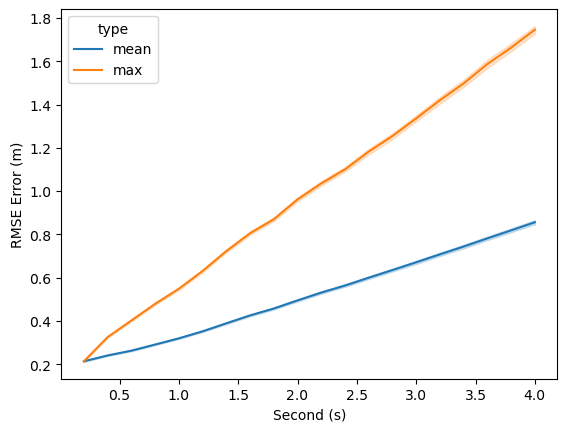

In [73]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, predictions.size(1) + 1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 5 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type',) #  errorbar=('sd', 1),
plt.savefig(f'../model/{model_name}/{folder_name}/res.png')
plt.show()

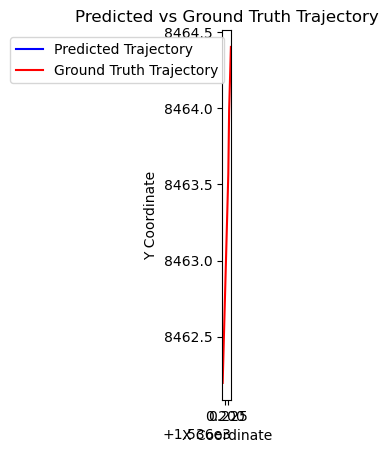

In [74]:
# visualize

time_stamp = 2899
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pred = predictions[time_stamp, :, :].cpu().numpy()
truth = truths[time_stamp, :, :].cpu().numpy()

fig, ax = plt.subplots()

# equal axis
ax.set_aspect('equal')

ax.plot(pred[:, 0], pred[:, 1], color='blue', label='Predicted Trajectory')
ax.plot(truth[:, 0], truth[:, 1], color='red', label='Ground Truth Trajectory')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Predicted vs Ground Truth Trajectory')
ax.legend()
plt.show()

In [75]:
exp_results = df.groupby(by=['Second (s)', 'type']).mean().unstack()['RMSE Error (m)']
exp_results.to_csv(f'../model/{model_name}/{folder_name}/result.csv')
exp_results

type,max,mean
Second (s),,
0.2,0.213196,0.213196
0.4,0.325087,0.240143
0.6,0.401820,0.262324
0.8,0.478753,0.290556
1.0,0.548466,0.319244
1.2,0.630744,0.351674
1.4,0.722682,0.388734
1.6,0.805256,0.425171
1.8,0.869738,0.457087


### Export JIT Model

Integrate partial of data processing into the model

In [76]:
# # EXPORT_MODEL = True

# # # model.load_state_dict(torch.load("/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/Jul09_20-37-37/model_40000.pt"))
# # if EXPORT_MODEL:
# #     model.eval()
# #     model.to('cpu')
# #     script_module = torch.jit.script(model)
# #     os.makedirs(f'../model/exported/', exist_ok=True)
# #     script_module.save("../exported/model_tft_vqvae_cpu.pt")

# stats = {}
# '''
# mean: tensor[]
# '''

# for keys, values in stats_dict.items():
#     stats[keys] = torch.tensor(values.to_list()).view(1,1,-1)
    
# class TFT_EXP(nn.Module):
#     def __init__(self, model:EnhancedTFT, stats:dict):
#         super(TFT_EXP, self).__init__()
#         self.stats = stats
#         self.register_buffer('mean', self.stats['mean'])
#         self.register_buffer('std', self.stats['std'])
#         self.register_buffer('min', self.stats['min'])
#         self.register_buffer('max', self.stats['max'])
#         self.TFT = model
#         self.num_steps = model.num_steps
#         self.num_outputs = model.num_outputs # =2

#     def forward(self, x, mask: Optional[torch.Tensor]=None):
#         single = False
#         if len(x.shape) == 2:
#             x = x.unsqueeze(0)
#             single = True
        
#         # normalize
#         x = (x - self.mean) / self.std
#         x = (x - self.min) / (self.max - self.min)
#         # residual
#         current_pos_input = x[:, -1, :2].clone().unsqueeze(1).repeat(1, x.shape[1], 1)
#         current_pos_output = x[:, -1, :2].clone().unsqueeze(1).repeat(1, self.num_steps, 1)
#         x[:, :, :2] = x[:, :, :2] - current_pos_input
        
#         # pass through TFT
#         outputs, vq_loss, perplexity = self.TFT(x, mask)
#         outputs = outputs.detach()
        
#         # de-residual
#         outputs[:, :, :2] = outputs[:, :, :2] + current_pos_output
        
#         # denormalize
#         outputs = outputs * (self.max[:,:,:self.num_outputs] - self.min[:,:,:self.num_outputs]) + self.min[:,:,:self.num_outputs]
#         outputs = outputs * self.std[:,:,:self.num_outputs] + self.mean[:,:,:self.num_outputs]
        
#         if single:
#             outputs = outputs.squeeze(0)
#         return outputs

# tft_exp = TFT_EXP(model, stats)
# tft_exp.to('cpu')
# tft_exp.eval()
# # script_module = torch.jit.script(tft_exp)
# # os.makedirs(f'../model/exported/', exist_ok=True)
# # script_module.save("../exported/model_tft_vqvae_cpu_preproc.pt")

# # export to onnx

# dummy_input = torch.randn(1, lookback, feature_dim)
# print(f"Input shape: {dummy_input.shape}")

# # Export the wrapped model to ONNX format
# torch.onnx.export(
#     tft_exp,                   # Wrapped model to export
#     dummy_input,                     # Model input
#     "../exported/tft_1111.onnx",              # Output file name
#     export_params=True,              # Store the trained parameter weights inside the model file
#     opset_version=13,                # Set the ONNX opset version (adjust as needed)
#     do_constant_folding=True,        # Whether to execute constant folding for optimization
#     input_names=['input'],           # The model's input names
#     output_names=['output'],         # The model's output names
#     # dynamic_axes={
#     #     'input': {0: 'batch_size'},  # Dynamic batch_size and sequence_length
#     #     'output': {0: 'batch_size'}  # Dynamic batch_size for the output
#     # }
# )
        

In [77]:
# import onnxruntime as ort
# import numpy as np

# # Path to your ONNX model
# model_path = "../exported/tft_1111.onnx"

# # Create an inference session
# session = ort.InferenceSession(model_path)

# # Get the name of the input node
# input_name = session.get_inputs()[0].name

# for file in os.listdir(dir):
#     if file.endswith('.pkl'):
#         df = process_data(dir+file)
#     break

# df = df[['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
#        'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
#        'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
#        'intent_to_cross', 'Gazing_station', 'possible_interaction',
#        'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
#        'closest_station', 'distance_to_closest_station',
#        'distance_to_closest_station_X', 'distance_to_closest_station_Y',
#        'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
#        'GazeDirection_Z', 'AGV_X', 'AGV_Y',
#        'looking_at_closest_station']]

# start_idx = 100
# input = df.iloc[200:200+lookback].astype(np.float32).values

# # add batch
# input = input[np.newaxis, :, :]
# # Run the model
# output = session.run(None, {input_name: input.astype(np.float32)})[0]

# output



### Save data (for interactive visualization)

In [78]:
# model = torch.jit.load("../exported/model_tft_vqvae_cpu.pt")

# test_ds = MyDataset(lookback=lookback)
# all_ds = ds.dataset
# test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
# X_list, y_list = test_ds.generate_data(return_list=True, future_steps=future_steps)


In [79]:
# from torch.utils.data import DataLoader, Dataset, TensorDataset

# normalize_dict = stats_dict
# pred_data = []
# truth_data = []
# input_data = []
# model.eval()
# device = 'cpu'
# for i, (X, y) in enumerate(zip(X_list, y_list)):
#     current_pos_input = X[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
#     current_pos_output = X[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1).to(device)
#     X[:, :, :2] = X[:, :, :2] - current_pos_input

#     predictions = model(X.float().to(device))[0][:, :future_steps, :2]
#     predictions = predictions + current_pos_output
#     predictions = predictions.to('cpu')
    
#     truths = y[:, :future_steps, :2]
#     X[:, :, :2] = X[:, :, :2] + current_pos_input
#     model_input = X.float().to(device)[:, :lookback, :2]
#     trajectory_id = i
    
#     # reverse normalization
#     for idx, key_ in enumerate(["User_X", "User_Y"]):
#         predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
#     for group_id in range(predictions.shape[0]):
#         for time_step in range(predictions.shape[1]):
#             pred_x, pred_y = predictions[group_id, time_step]
#             pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

#             truth_x, truth_y = truths[group_id, time_step]
#             truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])
        
#         for time_step in range(lookback):
#             input_x, input_y = model_input[group_id, time_step]
#             input_data.append([trajectory_id, group_id, time_step, input_x.item(), input_y.item()])
            

# pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# input_df = pd.DataFrame(input_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [80]:
# files_to_remove = [
#     "../data/pred_tra_all.pkl",
#     "../data/truth_tra_all.pkl", 
#     "../data/input_tra_all.pkl"
# ]

# for file_path in files_to_remove:
#     if os.path.exists(file_path):
#         os.remove(file_path)

# truth_df.to_pickle("../data/truth_tra_all.pkl")
# pred_df.to_pickle("../data/pred_tra_all.pkl")
# input_df.to_pickle("../data/input_tra_all.pkl")